# Recommend top restaurants based on consumer preference using popularity and collaborative recommender systems

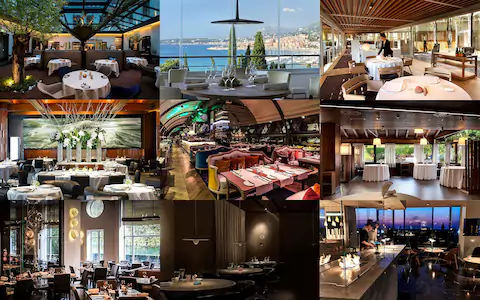

Recommender/recommendation system is a subclass of information filtering system that seeks to predict the rating/ preference a user would give to an item.

They are primarily used in applications where a person/ entity is involved with a product/ service. To further improve their experience with this product, we try to personalize it to their needs. For this we have to look up at their past interactions with this product.

In one line -> **Specialized content for everyone.**

For further info, [Wiki](https://en.wikipedia.org/wiki/Recommender_system)

**Types of Recommender System**

* 1). [Popularity Based](https://www.kaggle.com/sasha18/popularity-based-movie-recommendation)
* 2). Classification Based
* 3). [Content Based](https://www.kaggle.com/sasha18/recommend-books-using-count-tfidf-on-titles)
* 4). Collaborative Based
* 5). [Hybrid Based (Content + Collaborative)](https://www.kaggle.com/sasha18/recommend-top-restaurants-based-on-preference)
* 6). [Association Based Rule Mining](https://www.kaggle.com/sasha18/perform-market-basket-analysis-with-e-comm-data)

We use 'rating_final' dataset to recommend restaurants based on popularity & based on Collaborative that is the ratings given by other users.

# Import packages and dataset

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #this helps to full output and not only the last lines of putput

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.sparse

import warnings
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv('../input/restaurant-data-with-consumer-ratings/rating_final.csv')
data.head()

userID  placeID  rating  food_rating  service_rating
0  U1077   135085       2            2               2
1  U1077   135038       2            2               1
2  U1077   132825       2            2               2
3  U1077   135060       1            2               2
4  U1068   135104       1            1               2

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 5 columns):
userID            1161 non-null object
placeID           1161 non-null int64
rating            1161 non-null int64
food_rating       1161 non-null int64
service_rating    1161 non-null int64
dtypes: int64(4), object(1)
memory usage: 45.5+ KB


In [4]:
#Summary statistics
data.describe(include = 'all').transpose()

count unique    top freq     mean       std     min     25%  \
userID          1161    138  U1061   18      NaN       NaN     NaN     NaN   
placeID         1161    NaN    NaN  NaN   134192   1100.92  132560  132856   
rating          1161    NaN    NaN  NaN  1.19983  0.773282       0       1   
food_rating     1161    NaN    NaN  NaN  1.21533  0.792294       0       1   
service_rating  1161    NaN    NaN  NaN  1.09044  0.790844       0       0   

                   50%     75%     max  
userID             NaN     NaN     NaN  
placeID         135030  135059  135109  
rating               1       2       2  
food_rating          1       2       2  
service_rating       1       2       2

# Exploratory Data Analytics

To understand the dataset in detail, its important to perform EDA.

**Let's answer few questions:**
* No.of unique users, unique restaurants, no. of ratings, food_ratings, service_ratings
* How many times has a user rated
* How many times has a restaurant been rated
* What's the rating distribution for food, service

In [5]:
#No.of unique users, restaurants, no. of ratings, food_ratings, service_ratings
print('Unique users: ', data['userID'].nunique())
print('Unique restaurant: ', data['placeID'].nunique())
print('Total no.of ratings given: ', data['rating'].count())
print('Total no.of food ratings given: ', data['food_rating'].count())
print('Total no.of service ratings given: ', data['service_rating'].count())

Unique users:  138
Unique restaurant:  130
Total no.of ratings given:  1161
Total no.of food ratings given:  1161
Total no.of service ratings given:  1161


In [6]:
# How many times has a user rated
most_rated_users = data['userID'].value_counts()
most_rated_users

U1061    18
U1106    18
U1134    16
U1024    15
U1022    14
         ..
U1070     3
U1047     3
U1031     3
U1107     3
U1039     3
Name: userID, Length: 138, dtype: int64

In [7]:
#How many times has a restaurant been rated
most_rated_restaurants = data['placeID'].value_counts()
most_rated_restaurants

135085    36
132825    32
135032    28
135052    25
132834    25
          ..
135016     3
132766     3
134975     3
132668     3
135011     3
Name: placeID, Length: 130, dtype: int64

<Figure size 576x360 with 0 Axes>

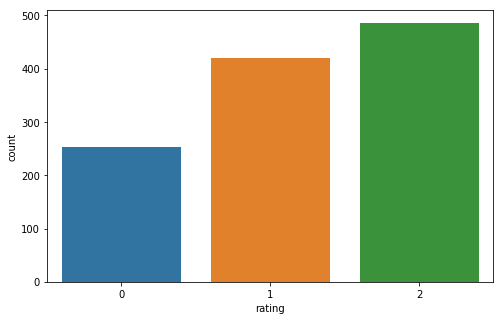

In [8]:
#What's the rating distribution
plt.figure(figsize = (8,5))
sns.countplot(data['rating'])

<Figure size 576x360 with 0 Axes>

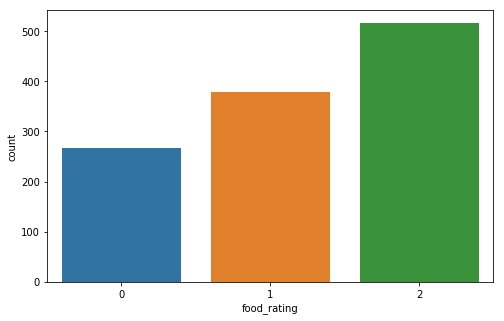

In [9]:
#What's the food rating distribution
plt.figure(figsize = (8,5))
sns.countplot(data['food_rating'])

<Figure size 576x360 with 0 Axes>

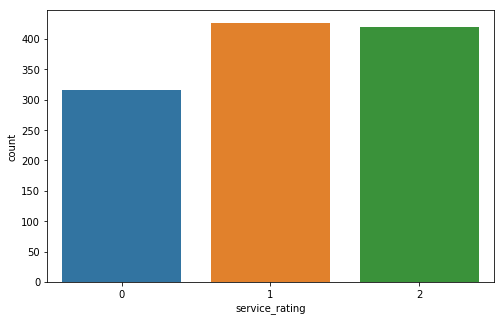

In [10]:
#What's the service rating distribution
plt.figure(figsize = (8,5))
sns.countplot(data['service_rating'])

**With this EDA, we can infer:**
* All 130 restaurants were rated minimum 3 times on a scale of 0 to 2
* All 138 users have rated minimum 3 times
* As for the rating distribution, users were quite satisfied with restaurants as significant no. of users have rated 1,2

Total no. of ratings were 1161, however if each of the user would have rated all the restaurants it would have been a total of 138 * 130 = 17940 ratings

**For a recommendation system model to recommend top prefered restaurants, we need to have each of the users rating all the restaurants. As this is not possible, we have to predict ratings that a user would give to a restaurant.**

**Let's build a dataset containing users who have actively rated atleast n times.**

In [11]:
#How many users have rated more than n places ?
n = 3
user_counts = most_rated_users[most_rated_users > n]
len(user_counts)
user_counts

128

U1061    18
U1106    18
U1134    16
U1024    15
U1022    14
         ..
U1127     4
U1060     4
U1121     4
U1040     4
U1023     4
Name: userID, Length: 128, dtype: int64

In [12]:
#No. of ratings given
user_counts.sum()

1131

In [13]:
#Retrieve all ratings given by the above users from the full data
data_final = data[data['userID'].isin(user_counts.index)]
data_final

userID  placeID  rating  food_rating  service_rating
0     U1077   135085       2            2               2
1     U1077   135038       2            2               1
2     U1077   132825       2            2               2
3     U1077   135060       1            2               2
4     U1068   135104       1            1               2
...     ...      ...     ...          ...             ...
1155  U1043   132732       1            1               1
1156  U1043   132630       1            1               1
1158  U1068   132733       1            1               0
1159  U1068   132594       1            1               1
1160  U1068   132660       0            0               0

[1131 rows x 5 columns]

In [14]:
final_ratings_matrix = data_final.pivot(index = 'userID', columns = 'placeID', values = 'rating').fillna(0)
final_ratings_matrix.head()

placeID  132560  132561  132564  132572  132583  132584  132594  132608  \
userID                                                                    
U1001       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
U1002       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
U1003       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
U1004       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
U1005       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

placeID  132609  132613  ...  135080  135081  135082  135085  135086  135088  \
userID                   ...                                                   
U1001       0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
U1002       0.0     0.0  ...     0.0     0.0     0.0     1.0     0.0     0.0   
U1003       0.0     0.0  ...     2.0     0.0     0.0     0.0     0.0     0.0   
U1004       0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
U1005       0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

placeID  135104  135106  135108  135109  
userID                                   
U1001       0.0     0.0     0.0     0.0  
U1002       0.0     1.0     0.0     0.0  
U1003       0.0     0.0     0.0     0.0  
U1004       0.0     2.0     0.0     0.0  
U1005       0.0     0.0     0.0     0.0  

[5 rows x 130 columns]

In [15]:
#Lets calculate the density of the matrix. This is to see how many possible ratings could be given and exactly how many ratings were given 

#No. of ratings given
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings: ', given_num_of_ratings)

#Total no. of ratings that could have been given 
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings: ', possible_num_of_ratings)

#Calculate matrix density
density = (given_num_of_ratings / possible_num_of_ratings) * 100
print('density: {:4.2f}%'.format(density))

given_num_of_ratings:  884
possible_num_of_ratings:  16640
density: 5.31%


Many ratings are 0 so we are not sure if they are really 0 or users haven't rated them.

# Popularity based Recommender Model

As the name suggests it recommends based on what is currently trending/ popular across the site. This is particularly useful when you don't have past data as a reference to recommend product to the user. It is not tailor fit for any particular group of audience or movie.

*For a better understanding you can refer to kernel -> [Popularity based Movie Recommender](https://www.kaggle.com/sasha18/popularity-based-movie-recommendation)*

**Things to do:**
* No. of users who have rated a resto
* Rank them based on scores
* Recommend most popular places

In [16]:
#No. of users who have rated a resto
data_grouped = data.groupby('placeID').agg({'userID':'count'}).reset_index()
data_grouped.rename(columns = {'userID': 'score'}, inplace = True )
data_sort = data_grouped.sort_values(['score','placeID'], ascending = False)
data_sort.head()

placeID  score
123   135085     36
31    132825     32
80    135032     28
98    135052     25
33    132834     25

In [17]:
#Let's rank them based on scores
data_sort['Rank'] = data_sort['score'].rank(ascending = 0, method = 'first')
pop_recom = data_sort
pop_recom.head()

placeID  score  Rank
123   135085     36   1.0
31    132825     32   2.0
80    135032     28   3.0
98    135052     25   4.0
33    132834     25   5.0

In [18]:
print('Here are the most popular restaurants')
pop_recom[['placeID','score','Rank']].head()

Here are the most popular restaurants


placeID  score  Rank
123   135085     36   1.0
31    132825     32   2.0
80    135032     28   3.0
98    135052     25   4.0
33    132834     25   5.0

**As this is a popularity based recommendation, it is not personalized hence the recommendation remain the same for all the users.**

# Collaborative filtering model

Using Model based Collaborative filtering: Singular Value Decomposition

**Things to do:**
* Transform the data into a pivot table -> Format required for colab model
* Create a user_index column to count the no. of users -> Change naming convention of user by using counter
* Apply SVD method on a large sparse matrix -> To predict ratings for all resto that weren't rated by a user
* Predict ratings for all restaurants not rated by a user using SVD
* Wrap it all into a function

In [19]:
#Transform the data into a pivot table -> Format required for colab model
pivot_data = data_final.pivot(index = 'userID', columns = 'placeID', values = 'rating').fillna(0)
pivot_data.shape
pivot_data.head()

(128, 130)

placeID  132560  132561  132564  132572  132583  132584  132594  132608  \
userID                                                                    
U1001       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
U1002       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
U1003       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
U1004       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
U1005       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

placeID  132609  132613  ...  135080  135081  135082  135085  135086  135088  \
userID                   ...                                                   
U1001       0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
U1002       0.0     0.0  ...     0.0     0.0     0.0     1.0     0.0     0.0   
U1003       0.0     0.0  ...     2.0     0.0     0.0     0.0     0.0     0.0   
U1004       0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
U1005       0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

placeID  135104  135106  135108  135109  
userID                                   
U1001       0.0     0.0     0.0     0.0  
U1002       0.0     1.0     0.0     0.0  
U1003       0.0     0.0     0.0     0.0  
U1004       0.0     2.0     0.0     0.0  
U1005       0.0     0.0     0.0     0.0  

[5 rows x 130 columns]

In [20]:
#Create a user_index column to count the no. of users -> Change naming convention of user by using counter
pivot_data['user_index'] = np.arange(0, pivot_data.shape[0],1)
pivot_data.head()

placeID  132560  132561  132564  132572  132583  132584  132594  132608  \
userID                                                                    
U1001       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
U1002       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
U1003       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
U1004       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
U1005       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

placeID  132609  132613  ...  135081  135082  135085  135086  135088  135104  \
userID                   ...                                                   
U1001       0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
U1002       0.0     0.0  ...     0.0     0.0     1.0     0.0     0.0     0.0   
U1003       0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
U1004       0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
U1005       0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

placeID  135106  135108  135109  user_index  
userID                                       
U1001       0.0     0.0     0.0           0  
U1002       1.0     0.0     0.0           1  
U1003       0.0     0.0     0.0           2  
U1004       2.0     0.0     0.0           3  
U1005       0.0     0.0     0.0           4  

[5 rows x 131 columns]

In [21]:
pivot_data.set_index(['user_index'], inplace = True)
pivot_data.head()

placeID     132560  132561  132564  132572  132583  132584  132594  132608  \
user_index                                                                   
0              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

placeID     132609  132613  ...  135080  135081  135082  135085  135086  \
user_index                  ...                                           
0              0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
1              0.0     0.0  ...     0.0     0.0     0.0     1.0     0.0   
2              0.0     0.0  ...     2.0     0.0     0.0     0.0     0.0   
3              0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
4              0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   

placeID     135088  135104  135106  135108  135109  
user_index                                          
0              0.0     0.0     0.0     0.0     0.0  
1              0.0     0.0     1.0     0.0     0.0  
2              0.0     0.0     0.0     0.0     0.0  
3              0.0     0.0     2.0     0.0     0.0  
4              0.0     0.0     0.0     0.0     0.0  

[5 rows x 130 columns]

In [22]:
#Applying SVD method on a large sparse matrix -> To predict ratings for all resto that weren't rated by a user

from scipy.sparse.linalg import svds

#SVD
U,s, VT = svds(pivot_data, k = 10)

#Construct diagonal array in SVD
sigma = np.diag(s)

#Applying SVD would output 3 parameters namely
print("U = ",U) #Orthogonal matrix
print('************************************************')
print("S = ",s) #Singular values
print('************************************************')
print("VT = ", VT) #Transpose of Orthogonal matrix

U =  [[ 2.78715782e-02  2.91618540e-02  7.70811695e-02 ... -4.87700614e-02
  -3.93023517e-02  7.74356179e-02]
 [-3.24688962e-02 -8.01036269e-02 -2.06369536e-01 ... -7.98147645e-02
   2.17442564e-02  1.32574089e-01]
 [ 2.51297171e-01  7.30422012e-02 -1.15762870e-01 ... -7.96291336e-02
   2.38070423e-01  1.26700572e-01]
 ...
 [-5.76434516e-18 -1.29663781e-17 -3.83362105e-19 ...  1.74916795e-17
   3.87478657e-18 -2.63220802e-18]
 [-1.28161536e-01 -2.45862716e-01  3.70810741e-02 ...  9.95513466e-02
   1.42823533e-01  7.57573476e-02]
 [ 6.22639806e-02 -1.84539855e-01 -2.04435481e-01 ... -1.16345218e-01
   1.73077175e-01  2.10689444e-01]]
************************************************
S =  [ 7.51719179  7.67564253  8.13565563  8.35409151  8.83110639  9.18332145
  9.18346565  9.70983532 12.38003756 18.97979143]
************************************************
VT =  [[ 7.24536424e-18 -2.33910379e-18  6.77621042e-18 ...  9.18664897e-03
   8.29136455e-02 -5.22672641e-17]
 [ 2.48248454e-17  9.9

**Note that for sparse matrices, you can use the sparse.linalg.svds() function to perform the decomposition. SVD is useful in many tasks, such as data compression, noise reduction similar to Principal Component Analysis and Latent Semantic Indexing (LSI), used in document retrieval and word similarity in Text mining**

In [23]:
#Predict ratings for all restaurants not rated by a user using SVD
all_user_predicted_ratings = np.dot(np.dot(U,sigma), VT)

#Predicted ratings
pred_data = pd.DataFrame(all_user_predicted_ratings, columns = pivot_data.columns)
pred_data.head()

placeID        132560        132561        132564    132572        132583  \
0        1.084612e-17 -8.743162e-18  2.266236e-18  0.175423 -4.550385e-17   
1       -1.179439e-17 -3.155926e-18 -1.502388e-17  0.204657  1.011937e-16   
2        4.343965e-17  5.105161e-18  9.131529e-18  0.274472  2.927210e-16   
3       -4.969270e-17 -1.424436e-17 -2.924324e-17  0.480896 -2.849674e-16   
4       -1.994700e-17  7.798705e-18 -1.351082e-17 -0.105621  2.173700e-16   

placeID        132584        132594        132608        132609        132613  \
0        2.614207e-17  1.110524e-17  1.628876e-17  1.119519e-17  1.827650e-17   
1       -7.080447e-17 -2.481193e-17 -3.559388e-17 -2.468279e-17 -9.059076e-17   
2        5.216395e-17  4.420153e-17  4.944536e-17 -5.255614e-18  5.098524e-17   
3       -1.271179e-16 -9.296879e-17 -3.643146e-17 -5.954542e-18 -1.449949e-16   
4       -4.473476e-17 -3.880175e-17 -1.643495e-17 -2.832675e-18 -7.237177e-18   

placeID  ...    135080    135081    135082    135085    135086        135088  \
0        ...  0.141167  0.204458  0.066725  0.227847 -0.049773 -1.813630e-17   
1        ...  0.196347  0.099066  0.031653  1.276811 -0.040446  7.125073e-17   
2        ...  0.946897  0.220074  0.039438  0.559835  0.299039  1.798478e-16   
3        ...  0.022667  0.051184 -0.035111 -0.457882  0.410617 -2.176384e-16   
4        ... -0.081746  0.957039  0.233822 -0.122340  0.019016  1.523344e-16   

placeID        135104    135106    135108        135109  
0        2.444128e-17  0.217707  0.119304 -2.250833e-17  
1       -7.822497e-17  0.401924  0.082374  6.472344e-17  
2        2.960399e-17  0.034631  0.153178  1.418414e-16  
3       -1.632277e-16  0.649489 -0.160043 -1.658445e-16  
4       -6.587765e-17  0.145661  0.211434  8.939784e-17  

[5 rows x 130 columns]

**Wrapping into all into a function**

**Things to do**
* Create a function to recommend places with highest predicted ratings
* Use the function to recommend places based on userID, past ratings, predicted ratings, num of places 

In [24]:
#Recommend places with the highest predicted ratings

def recommend_places(userID, pivot_data, pred_data, num_recommendations):
    user_index  = userID-1 #index starts at 0

    sorted_user_ratings = pivot_data.iloc[user_index].sort_values(ascending = False) #sort user ratings

    sorted_user_predictions = pred_data.iloc[user_index].sort_values(ascending = False)#sorted_user_predictions
    
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis = 1)
    temp.index.name = 'Recommended Places'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending = False)
    print('\n Below are the recommended places for user(user_id = {}):\n'. format(userID))
    print(temp.head(num_recommendations))

In [25]:
#Recommend places based on userID, past ratings, predicted ratings, num of places 

userID = 12
num_recommedations = 5
recommend_places(userID, pivot_data, pred_data, num_recommedations)


 Below are the recommended places for user(user_id = 12):

                    user_ratings  user_predictions
Recommended Places                                
135046                       0.0          0.780975
135026                       0.0          0.465279
135058                       0.0          0.458938
135055                       0.0          0.455777
135045                       0.0          0.440416


# Evaluate model using RMSE

RMSE is the square root of the average of squared errors. The effect of each error on RMSE is proportional to the size of the squared error; thus larger errors have a disproportionately large effect on RMSE. Consequently, RMSE is sensitive to outliers.

***For more info -> [Wiki](https://en.wikipedia.org/wiki/Root-mean-square_deviation)***

**Things to do:**
* Actual ratings given by user
* Predicted ratings for a place
* Calculate RMSE

In [26]:
#Actual ratings given by the users
final_ratings_matrix.head()

#Average actual rating for each place

final_ratings_matrix.mean().head()

placeID  132560  132561  132564  132572  132583  132584  132594  132608  \
userID                                                                    
U1001       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
U1002       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
U1003       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
U1004       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
U1005       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

placeID  132609  132613  ...  135080  135081  135082  135085  135086  135088  \
userID                   ...                                                   
U1001       0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
U1002       0.0     0.0  ...     0.0     0.0     0.0     1.0     0.0     0.0   
U1003       0.0     0.0  ...     2.0     0.0     0.0     0.0     0.0     0.0   
U1004       0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
U1005       0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

placeID  135104  135106  135108  135109  
userID                                   
U1001       0.0     0.0     0.0     0.0  
U1002       0.0     1.0     0.0     0.0  
U1003       0.0     0.0     0.0     0.0  
U1004       0.0     2.0     0.0     0.0  
U1005       0.0     0.0     0.0     0.0  

[5 rows x 130 columns]

placeID
132560    0.015625
132561    0.023438
132564    0.023438
132572    0.117188
132583    0.031250
dtype: float64

In [27]:
#Predicted ratings for a place
pred_data.head()

#Average predicted rating for each place
pred_data.mean().head()

placeID        132560        132561        132564    132572        132583  \
0        1.084612e-17 -8.743162e-18  2.266236e-18  0.175423 -4.550385e-17   
1       -1.179439e-17 -3.155926e-18 -1.502388e-17  0.204657  1.011937e-16   
2        4.343965e-17  5.105161e-18  9.131529e-18  0.274472  2.927210e-16   
3       -4.969270e-17 -1.424436e-17 -2.924324e-17  0.480896 -2.849674e-16   
4       -1.994700e-17  7.798705e-18 -1.351082e-17 -0.105621  2.173700e-16   

placeID        132584        132594        132608        132609        132613  \
0        2.614207e-17  1.110524e-17  1.628876e-17  1.119519e-17  1.827650e-17   
1       -7.080447e-17 -2.481193e-17 -3.559388e-17 -2.468279e-17 -9.059076e-17   
2        5.216395e-17  4.420153e-17  4.944536e-17 -5.255614e-18  5.098524e-17   
3       -1.271179e-16 -9.296879e-17 -3.643146e-17 -5.954542e-18 -1.449949e-16   
4       -4.473476e-17 -3.880175e-17 -1.643495e-17 -2.832675e-18 -7.237177e-18   

placeID  ...    135080    135081    135082    135085    135086        135088  \
0        ...  0.141167  0.204458  0.066725  0.227847 -0.049773 -1.813630e-17   
1        ...  0.196347  0.099066  0.031653  1.276811 -0.040446  7.125073e-17   
2        ...  0.946897  0.220074  0.039438  0.559835  0.299039  1.798478e-16   
3        ...  0.022667  0.051184 -0.035111 -0.457882  0.410617 -2.176384e-16   
4        ... -0.081746  0.957039  0.233822 -0.122340  0.019016  1.523344e-16   

placeID        135104    135106    135108        135109  
0        2.444128e-17  0.217707  0.119304 -2.250833e-17  
1       -7.822497e-17  0.401924  0.082374  6.472344e-17  
2        2.960399e-17  0.034631  0.153178  1.418414e-16  
3       -1.632277e-16  0.649489 -0.160043 -1.658445e-16  
4       -6.587765e-17  0.145661  0.211434  8.939784e-17  

[5 rows x 130 columns]

placeID
132560   -1.171132e-18
132561    3.334107e-18
132564   -1.491341e-18
132572    9.900262e-02
132583    3.323385e-02
dtype: float64

In [28]:
#Calculate RMSE

rmse_data = pd.concat([final_ratings_matrix.mean(), pred_data.mean()], axis = 1)
rmse_data.columns = ['Avg_actual_ratings','Avg_predicted_ratings']
print(rmse_data.shape)
rmse_data['place_index'] = np.arange(0, rmse_data.shape[0],1)
rmse_data.head()

(130, 2)


Avg_actual_ratings  Avg_predicted_ratings  place_index
placeID                                                        
132560             0.015625          -1.171132e-18            0
132561             0.023438           3.334107e-18            1
132564             0.023438          -1.491341e-18            2
132572             0.117188           9.900262e-02            3
132583             0.031250           3.323385e-02            4

In [29]:
RMSE = round((((rmse_data.Avg_actual_ratings - rmse_data.Avg_predicted_ratings) ** 2).mean() ** 0.5),5)
print('\n RMSE SVD Model = {}\n'.format(RMSE))


 RMSE SVD Model = 0.01874



**Summarise your insights.**

Popularity-based recommender system is non-personalised and the recommendations are based on frequency counts, which may not be suitable to the user. Popularity based model will recommend the same 5 places to all users but Collaborative Filtering based model has recommended entire different list based on the user ratings.

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior/ interaction of the user and it is not dependent on any additional information. In this case we had ratings which showed interaction.